# semantic segmentation

- 이미지 분류를 영상단위가 아닌 픽셀단위로 실시하는 것
- 영상속에 있는 물체의 마스크를 생성
- class에 따라서 같은 물체로 인식해 마스킹

# architectures

## 1. Fully Convolutional Net (FCN)

- 입력 단부터 출력 단까지 모두 학습가능한 end-to-end 구조
- 이미지의 해상도와 상관없이 동작할 수 있어 호환성이 높은 구조

### 구조 
- 기존의 Fully connected layer는 convolutional layer에서 출력된 feature map을 flattening하여 입력으로 사용했기 때문에 공간정보를 반영하지 않음
- 공간정보를 반영하기 위해서 1X1 convolution연산이 필요
- 각 필터들이 하나의 weight column과 같이 동작하여, 공간 정보를 고려할 수 있고, 채널 수 만큼의 feature map을 얻음


@ 이러한 구조를 가져가더라도 넓은 receptive field를 확보하기 위해 pooling을 진행할 수록 저해상도의 출력을 얻게되는 문제가 발생
- 해결하기 위해 upsampling layer를 사용
- Transposed convolution, Upsample and convolution의 방법이 있음

### Transposed convolution
- 입력과 필터를 곱하여 각각 해당하는 위치에 출력하는 방식
- 겹치는 위치의 경우 그 값을 합하여 출력
- 중첩되는 부분에서 checkerboard artifact가 관찰 (바둑판모양으로 나타남)
- 이러한 이슈를 주의해서 stride와 filter 사이즈를 설정해야함
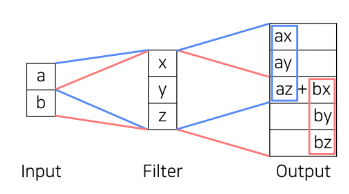

### Upsample and convolution
- 전체 upsampling 과정을 두 단계로 분리
- interpolation(보간)과정을 통해 upsampling시킨 후 학습가능한 형태를 더해주기 위해 convolution layer를 통과

## 레이어별 feature map의 해상도와 의미
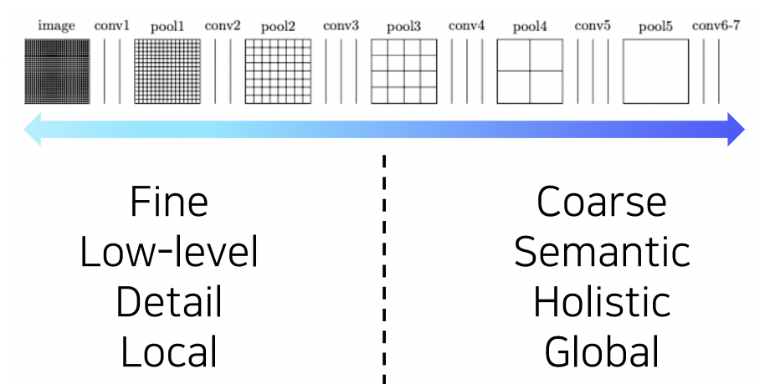
- 낮은 레이어 : 국지적, 작은 디테일, 작은차이에도 민감
- 높은 레이어 : 낮은 해상도, 전반적이고, 의미론적인 정보를 많이 포함
=> semantic segmentation에는 두개의 모든 정보가 필요

- 따라서 skip connection을 사용하여 낮은 레이어의 feature map을 직접적으로 고려할 수 있도록 설계
- 높은 레이어에 있던 activation map을 upsample(해상도를 크게 올림), 중간레이어에 activation map을 upsample 
- 단순히 합해주는 것이 아닌 concatenation을 수행해 연결


=> 중간 레이어의 feature map을 잘 고려하고 있는 경우에 더 좋은 semantic segmentation 결과를 보여줌

## 2. Hypercolumns

- FCN과 굉장히 유사한 아이디어를 기반으로 제안된 모델
- 낮은 레이어의 특징과 높은 레이어의 특징의 결합을 강조
- 별도의 알고리즘을 사용하여 얻은 물체의 bounding box를 입력으로 사용

## 3. U-Net

- 대칭적인 downsampling, upsampling 과정
- Downsampling 과정 : pooling을 통해 공간해상도를 절반으로 줄이고, 채널 수를 두배로 늘리는 방식
- upsampling 과정 : 공간해상도를 두배로 늘리고, 채널 수는 절반으로 줄이는 방식

@ 홀수의 공간해상도를 가지는 feature map이 입력된다면 downsampling 후 upsampling 되는 과정 동일한 feature map으로 돌아오지 못하는 현상이 나타나니 홀수 feature map을 주의해야함

## 4. DeepLab

### 4-1. Conditional Ramdon Fields(CRF)
- 후처리 도구로 활용
- Neural network를 기반으로 semantic segmentation을 수행했을 때 경계가 흐릿한 결과를 확인
- neural network이 출력을 입력과 비교하는 feedback loop이 부재한 단순 feed forward 구조를 가지고 있기 때문
- 극복방법 : rough한 score map과 이미지의 edge를 추출한 경계선을 활용하여 해당 score map이 경계선이 잘 맞아떨어지도록 반복적으로 확산

### 4-2 Dilated convolution 
- convolution filter들 사이에 dilation factor 만큼 일정공간을 넣어주는 방법
- 파라미터수는 늘어나지 않음
- receptive field가 증가하는 효과
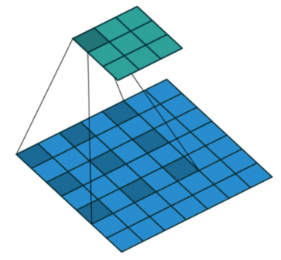

### 4-3 Depthwise separable convolution 
- 입력 해상도가 워낙 크기 때문에 연산이 복잡해지는 것을 완화하기 위해 dilated convolution을 depthwise separable convolution과 결합하여 사용
- 기존의 convolution : 하나의 출력 픽셀에 대한 activation을 얻기 위해 전체 필터 사이즈의 크기를 채널 축으로 내적 
- Depth-wise convolution : 각 채널 축으로 convolution을 수행하여 각 채널에 대한 값을 추출 -> 1x1 convolution을 통해 하나의 activation으로 추출 => 연산량을 크게 줄일 수 있음

### DeepLab v3+의 구조 
- 기본적인 CNN과 비슷한 구조
- dilated convolution을 적용해 더 큰 receptive field를 가지는 convoltution을 수행
- 영역별로 주변 물체와의 거리, 연관된 정보들이 서로 다르기 때문에 multi-scale을 다룰 수 있도록 spatial pyramid pooling을 수행
- 얻은 feature map들을 concatenation한 이후에 1x1 convolution을 적용하여 하나로 합침
- Decoder 단에서 낮은 레이어의 feature map과 pyramid pooling을 거친 feature map을 concatenation
- upsampling하여 최종 출력